In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real
from skopt.space import Integer
import joblib 

In [2]:
def load_data(directory, datafilename):
  try:
    f = open(f'{directory}/{datafilename}.csv', 'r')
  except FileNotFoundError:
    print('data file is missing. generating now.')
    if 'D0' in directory or 'D1' in directory:
      os.system(f'python D0D1_generation.py')
    else:
      os.system(f'python {directory}_generation.py')
    print('file generated.')
    f = open(f'{directory}/{datafilename}.csv', 'r')
  data = np.array(
      [[float(item2) for item2 in item.split(',') if len(item2)>0]
       for item in f.read().split('\n')[1:] if len(item)>0]  # includes the ID column also
  )
  return data

def test_model(model, X_test, y_test):
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", round(100*accuracy, 2), '%')
  conf_mat = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix:")
  print(conf_mat)
  return accuracy

def test_allDatasets(model, scaler):
  results = []
  print('\ntesting the model:')
  # over D1:
  print('\nover dataset D1:')
  data = load_data(directory='D1', datafilename='testD1')
  ID_test, X_test, y_test = data[:, 0].astype(int), data[:, 1:-1], data[:, -1]
  X_test = scaler.fit_transform(X_test)
  accuracy = test_model(model, X_test, y_test)
  results.append([model, 'testD1', accuracy])
  # over D2:
  print('\nover dataset D2:')
  data = load_data(directory='D2', datafilename='testD2')
  ID_test, X_test, y_test = data[:, 0].astype(int), data[:, 1:-1], data[:, -1]
  X_test = scaler.fit_transform(X_test)
  accuracy = test_model(model, X_test, y_test)
  results.append([model, 'testD2', accuracy])
  # over D3:
  print('\nover dataset D3:')
  data = load_data(directory='D3', datafilename='testD3')
  ID_test, X_test, y_test = data[:, 0].astype(int), data[:, 1:-1], data[:, -1]
  X_test = scaler.fit_transform(X_test)
  accuracy = test_model(model, X_test, y_test)
  results.append([model, 'testD3', accuracy])
  # over D42:
  for i in [-5, -50]:
    print(f'\nover dataset D42_{i}%:')
    data = load_data(directory='D42', datafilename=f'testD42_{i}percent')
    ID_test, X_test, y_test = data[:, 0].astype(int), data[:, 1:-1], data[:, -1]
    X_test = scaler.fit_transform(X_test)
    accuracy = test_model(model, X_test, y_test)
    results.append([model, f'testD4_{i}percent', accuracy])
    return results

In [3]:
'''
NOTE:
* this cell contains training algorithm for 5 models.
* output of this cell os only code-demostration.
* the cell after this is for model evaluation and employs models actually optimized in project.
'''

'''
training over D0:
'''
for model_tag in ['LogReg', 'SVM', 'DT', 'KNN', 'GaussNB']:
  print(f'\n{"-"*50}{model_tag}{"-"*50}')

  data = load_data(directory='D0', datafilename=f'trainD0')
  ID_train, X_train, y_train = data[:, 0].astype(int), data[:, 1:-1], data[:, -1]

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)

  # define hyperparameter space::
  if model_tag == 'LogReg':
    model = LogisticRegression()
    param_space = {
      'C': Real(1e-6, 1e+6, 'log-uniform'),
      'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
    }
  #   
  if model_tag == 'DT':
    model = DecisionTreeClassifier()
    param_space = {
      'criterion': ['gini', 'entropy', 'log_loss'],
      'splitter': ['best', 'random'],
      'min_samples_split': Integer(2, 100),
      'min_samples_leaf': Integer(2, 100)
    }
  # 
  if model_tag == 'GaussNB':
    model = GaussianNB()
    param_space = {
      'var_smoothing': Real(1e-12, 1e-7, 'log-uniform')
    }
  # 
  if model_tag == 'KNN':
    model = KNeighborsClassifier()
    param_space = {
      'n_neighbors': Integer(1, 50),
      'weights': ['uniform', 'distance'],
      'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
  # 
  if model_tag == 'SVM':
    model = SVC()
    param_space = {
      'C': Real(1e-6, 1e+6, 'log-uniform'),
      'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    }

  # hyperparam optimization:
  opt = BayesSearchCV(
    estimator=model, search_spaces=param_space,
    n_iter=1, cv=3, n_jobs=-1, n_points=3,
    verbose=3, scoring='accuracy'
  )
  opt.fit(X_train, y_train)

  # note that the actual optimization results have "final" in their filenames (kept in the folder)
  # this is for code-demostration only
  results_df = pd.DataFrame(opt.cv_results_)
  results_df.to_csv(f'{model_tag}_optResults.csv', index=False)

  # train with best param:
  best_params = opt.best_params_
  print('best_params:', best_params)
  if model_tag == 'LogReg': model = LogisticRegression(**best_params)
  if model_tag == 'DT': model = DecisionTreeClassifier(**best_params)
  if model_tag == 'RF': model = RandomForestClassifier(**best_params)
  if model_tag == 'GradBoost': model = GradientBoostingClassifier(**best_params)
  if model_tag == 'AdaBoost': model = AdaBoostClassifier(**best_params)
  if model_tag == 'GaussNB': model = GaussianNB(**best_params)
  if model_tag == 'KNN': model = KNeighborsClassifier(**best_params)
  if model_tag == 'SVM': model = SVC(**best_params)
  if model_tag == 'MLP': model = MLPClassifier(**best_params)
  model.fit(X_train, y_train)

  # note that the actually optimized models have "final" in their filenames (kept in the folder)
  joblib.dump(model, f'{model_tag}.joblib', compress=3)
  joblib.dump(scaler, f'{model_tag}_scaler.joblib', compress=3)
print('\n\ncomplete')


--------------------------------------------------LogReg--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
best_params: OrderedDict({'C': 1.8282660585570026e-06, 'solver': 'saga'})

--------------------------------------------------SVM--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
best_params: OrderedDict({'C': 1904.8162852068003, 'kernel': 'poly'})

--------------------------------------------------DT--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
best_params: OrderedDict({'criterion': 'entropy', 'min_samples_leaf': 39, 'min_samples_split': 30, 'splitter': 'random'})

--------------------------------------------------KNN--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
best_params: OrderedDict({'algorithm': 'auto', 'n_neighbors': 39, 'weights':

In [4]:
'''
evaluation over D1 to D4:
'''
for model_tag in ['LogReg', 'SVM', 'DT', 'KNN', 'GaussNB']:
  print(f'\n{"-"*50}{model_tag}{"-"*50}')

  results = []

  model = joblib.load(f'final_{model_tag}.joblib')
  scaler = joblib.load(f'final_{model_tag}_scaler.joblib')

  results += test_allDatasets(model, scaler)

  f = open('classification_AllExceptNN_results.txt', 'w')
  f.write('\n'.join(['\t'.join([str(item2) for item2 in item]) for item in results]))
  f.close()

print('\n\ncomplete')


--------------------------------------------------LogReg--------------------------------------------------

testing the model:

over dataset D1:
Accuracy: 94.6 %
Confusion Matrix:
[[960  11  16  15]
 [ 40 953   7   4]
 [ 53   3 942   1]
 [ 61   3   2 929]]

over dataset D2:
Accuracy: 90.15 %
Confusion Matrix:
[[1000    0    0    0]
 [ 107  893    0    0]
 [ 107    0  893    0]
 [ 180    0    0  820]]

over dataset D3:
Accuracy: 100.0 %
Confusion Matrix:
[[1000    0    0    0]
 [   0 1000    0    0]
 [   0    0 1000    0]
 [   0    0    0 1000]]

over dataset D42_-5%:
Accuracy: 78.0 %
Confusion Matrix:
[[181 119  94 607]
 [  0 981  12   7]
 [  1  12 974  14]
 [ 10   3   1 984]]

--------------------------------------------------SVM--------------------------------------------------

testing the model:

over dataset D1:
Accuracy: 72.02 %
Confusion Matrix:
[[1002    0    0    0]
 [ 373  631    0    0]
 [ 364    0  635    0]
 [ 382    0    0  613]]

over dataset D2:
Accuracy: 59.92 %
Confu

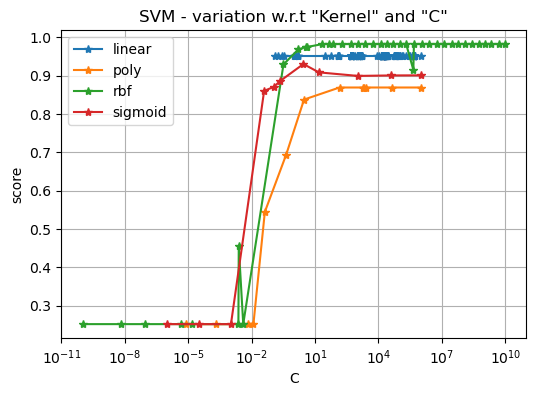

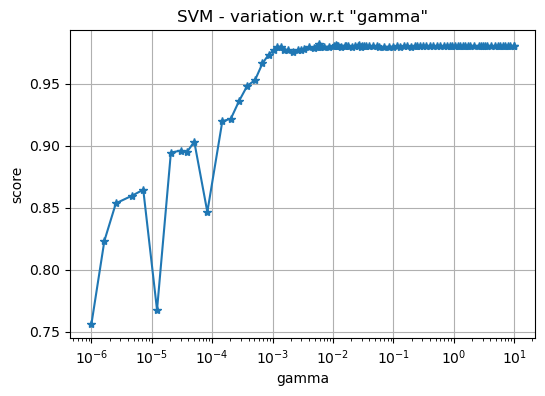

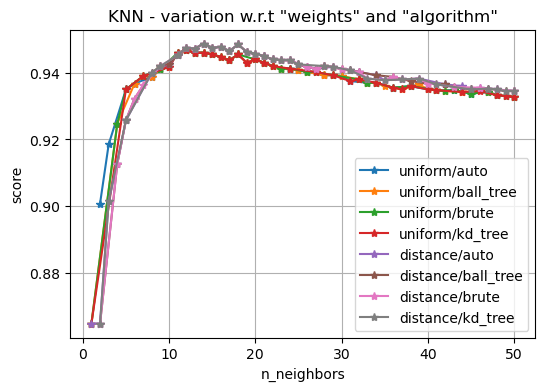

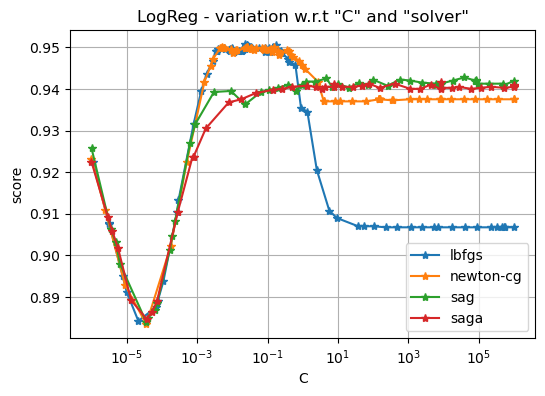

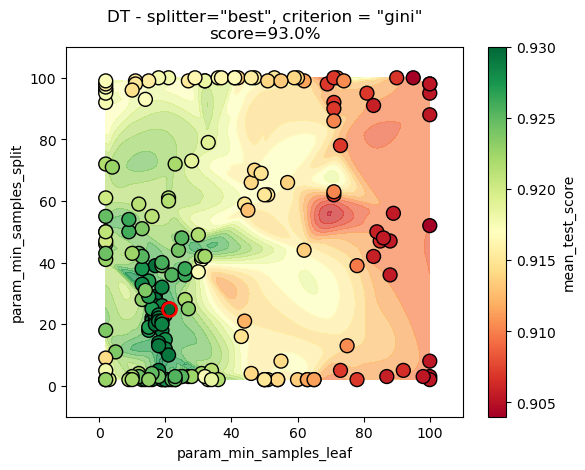

In [55]:
'''
plotting results:
'''

import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# -------------------------------------------------------------------------------------------------------------------
'''                            SVM - variation w.r.t "Kernel", "gamma" and "C"                                          '''
# -------------------------------------------------------------------------------------------------------------------
results = pd.read_csv('SVM_results_df_Kernel_C.csv')

plt.figure(figsize=(6,4))

linear_results = results[results['param_kernel'] == 'linear'].sort_values(by=['param_C'])
plt.plot(linear_results['param_C'], linear_results['mean_test_score'], '-*', label='linear')

poly_results = results[results['param_kernel'] == 'poly'].sort_values(by=['param_C'])
plt.plot(poly_results['param_C'], poly_results['mean_test_score'], '-*', label='poly')

rbf_results = results[results['param_kernel'] == 'rbf'].sort_values(by=['param_C'])
plt.plot(rbf_results['param_C'], rbf_results['mean_test_score'], '-*', label='rbf')

sigmoid_results = results[results['param_kernel'] == 'sigmoid'].sort_values(by=['param_C'])
plt.plot(sigmoid_results['param_C'], sigmoid_results['mean_test_score'], '-*', label='sigmoid')

plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('C')
plt.ylabel('score')
plt.title('SVM - variation w.r.t "Kernel" and "C"')
plt.show()


results = pd.read_csv('SVM_results_df_gamma.csv')

plt.figure(figsize=(6,4))
plt.plot(results['param_gamma'], results['mean_test_score'], '-*')
plt.xscale('log')
plt.grid()
# plt.legend()
plt.xlabel('gamma')
plt.ylabel('score')
plt.title('SVM - variation w.r.t "gamma"')
plt.show()
# -------------------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------------------
'''                   KNN - "algorithm", "weights" and "n_neighbors"          '''
# -------------------------------------------------------------------------------------------------------------------
results_ = pd.read_csv('KNN_results_df.csv')

plt.figure(figsize=(6,4))

for param_weights in ['uniform', 'distance']:
  results = results_[results_['param_weights'] == param_weights]

  auto_results = results[results['param_algorithm'] == 'auto'].sort_values(by=['param_n_neighbors'])
  plt.plot(auto_results['param_n_neighbors'], auto_results['mean_test_score'], '-*', label=f'{param_weights}/auto')

  ball_tree_results = results[results['param_algorithm'] == 'ball_tree'].sort_values(by=['param_n_neighbors'])
  plt.plot(ball_tree_results['param_n_neighbors'], ball_tree_results['mean_test_score'], '-*', label=f'{param_weights}/ball_tree')

  brute_results = results[results['param_algorithm'] == 'brute'].sort_values(by=['param_n_neighbors'])
  plt.plot(brute_results['param_n_neighbors'], brute_results['mean_test_score'], '-*', label=f'{param_weights}/brute')

  kd_tree_results = results[results['param_algorithm'] == 'kd_tree'].sort_values(by=['param_n_neighbors'])
  plt.plot(kd_tree_results['param_n_neighbors'], kd_tree_results['mean_test_score'], '-*', label=f'{param_weights}/kd_tree')

plt.xscale('linear')
plt.grid()
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.title('KNN - variation w.r.t "weights" and "algorithm"')
plt.show()
# -------------------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------------------
'''                   LogReg - "solver" and "C"          '''
# -------------------------------------------------------------------------------------------------------------------
results = pd.read_csv('LogReg_results_df.csv')

plt.figure(figsize=(6,4))

for param_solver in ['lbfgs', 'newton-cg', 'sag', 'saga']:
  C_results = results[results['param_solver'] == param_solver].sort_values(by=['param_C'])
  plt.plot(C_results['param_C'], C_results['mean_test_score'], '-*', label=f'{param_solver}')

plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('C')
plt.ylabel('score')
plt.title('LogReg - variation w.r.t "C" and "solver"')
plt.show()
# -------------------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------------------
'''                   DT - "splitter", "entropy", "param_min_samples_leaf" and "param_min_samples_split"          '''
# -------------------------------------------------------------------------------------------------------------------
model_tag = 'DT'
fixed_param, fixed_param_values = 'param_splitter', ['random', 'best']
parameters = ['param_criterion', 'param_min_samples_leaf', 'param_min_samples_split']
param_score = 'mean_test_score'

all_results = pd.read_csv(f'{model_tag}_results_df.csv')

for fixed_param_value in fixed_param_values:
  if fixed_param_value != 'best': continue
  # filter over fixed parameter:
  filtered_results = all_results[
    all_results[fixed_param] == fixed_param_value
  ][[fixed_param]+parameters+[param_score]]

  # individual plots:
  for item in sorted(filtered_results[parameters[0]].unique()):
    if item != 'gini': continue
    plotdf = filtered_results[filtered_results[parameters[0]] == item]
    best_score = plotdf[param_score].max()

    # plotdf = plotdf[parameters[1:]+[param_score]].sort_values(param_score)#parameters[1:])
    # print(plotdf)

    X = filtered_results[parameters[1]]
    Y = filtered_results[parameters[2]]
    Z = filtered_results[param_score]
    
    # for interpolated countour plot:
    grid_x, grid_y = np.meshgrid(
        np.linspace(X.min(), X.max(), 100),
        np.linspace(Y.min(), Y.max(), 100)
    )
    grid_z = griddata((X, Y), Z, (grid_x, grid_y), method='cubic')
    contour = plt.contourf(grid_x, grid_y, grid_z, levels=20, cmap='RdYlGn', alpha=0.7)
    # plt.colorbar(contour, label=param_score)
    plt.xlabel(parameters[1])
    plt.ylabel(parameters[2])
    plt.title(f'DT - splitter="{fixed_param_value}", criterion = "{item}"\nscore={round(100*best_score,2)}%')
    # for raw-data scatter plot:
    scatter = plt.scatter(X, Y, c=Z, cmap='RdYlGn', edgecolor='k', s=100, alpha=1)
    plt.colorbar(scatter, label=param_score)
    # mark best result:
    optimum = filtered_results.loc[filtered_results[param_score].idxmax()]  # Use idxmin for minimum
    plt.plot(
      optimum[parameters[1]], optimum[parameters[2]], 'o',
      markersize=10, markerfacecolor='none', markeredgecolor='red', markeredgewidth=2
    )
    plt.xlim(-10, 110)
    plt.ylim(-10, 110)
    plt.show()
# -------------------------------------------------------------------------------------------------------------------
